In [1]:
#!/usr/bin/env python3
from utils import *
import pandas as pd
import re
import matplotlib.pyplot as plt
import arviz

plt.rcParams['font.family'] = 'Arial'

cmap = ['#d62828', '#1d3557', '#f4a261', '#2a9d8f']


# Load epi data

In [2]:
cases_vaccines_genomes = pd.read_csv('cases_vaccines_genomes.csv')
cases_vaccines_genomes['date_float'] = cases_vaccines_genomes['date'].apply(lambda x: toYearFraction(x))

def load_epinow_results(path='../epi_inference/estimates_epinow.csv'):
    epinow_results = pd.read_csv(path)
    mask_date_lower = epinow_results['date'] >= '2022-05-01'
    mask_date_upper = epinow_results['date'] <= '2022-10-01'
    epinow_results = epinow_results[mask_date_lower & mask_date_upper].copy()
    epinow_results['date_float'] = epinow_results['date'].apply(lambda x: toYearFraction(x))

    epinow_re = epinow_results[epinow_results['variable'] == 'R'].copy()
    epinow_gr = epinow_results[epinow_results['variable'] == 'growth_rate'].copy()
    
    return epinow_results[mask_date_lower & mask_date_upper], epinow_re, epinow_gr


def load_reactidd_results(path='../epi_inference/estimates_reactidd.csv'):
    reactidd_results = pd.read_csv(path)
    reactidd_Rt = reactidd_results[reactidd_results['variable'] == 'Rt']
    reactidd_growth = reactidd_results[reactidd_results['variable'] == 'growth_rate']

    return reactidd_Rt, reactidd_growth


epinow_results, epinow_re, epinow_gr = load_epinow_results(path='../epi_inference/estimates_epinow.csv')
reactidd_Rt, reactidd_growth = load_reactidd_results(path='../epi_inference/estimates_reactidd.csv')

/var/folders/f4/_pkccln527547qwscbcjf2sr0000gn/T/ipykernel_8112/949832966.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return epinow_results[mask_date_lower & mask_date_upper], epinow_re, epinow_gr


# Load genomic data

In [3]:
local_beast_results_path = '../../../beast/EBDS_GMRF/top13_revised/transfer/combined.log' # user needs to run local phylogeography to generate this file
log_df = pd.read_csv(local_beast_results_path, sep='\t', comment='#')   

# calculate growth rate
for x in log_df.columns:
    if 'bdss.birthRate' in x:
        cluster = re.findall(r'\d+', x)[0]
        growth = (log_df.loc[:, x] - log_df.loc[:, f'bdss.deathRate{cluster}'])/365
        log_df[f'growth_rate{cluster}'] = growth

# When Re and growth rate drop below 1 and 0, respectively

In [4]:
def below_value(df, col, date_col, value=1):
    '''
    Return the first date after June 15 where the value of col is below the given value

    Parameters:
    df: pd.DataFrame
    col: str
    date_col: str
    value: float

    Returns:
    date: str
    '''

    mask = df[col] < value
    date_mask = df[date_col] >= '2022-06-15'
    date = df[mask & date_mask][date_col].min()
    return date


def cases_at_date(epi_df, date):
    '''
    Return the number of cases at a given date

    Parameters:
    epi_df: pd.DataFrame
    date: str

    Returns:
    cases: int
    '''
    mask = epi_df['date'] == date
    cases = epi_df[mask]['cases_cumulative'].values[0]
    return cases


def cases_at_value(df, col, date_col, epi_df, value=1):
    '''
    Return the number of cases at the first date where the value of col is below the given value

    Parameters:
    df: pd.DataFrame
    col: str
    date_col: str
    epi_df: pd.DataFrame
    value: float

    Returns:
    cases: int
    '''
    date = below_value(df, col, date_col, value)
    cases = cases_at_date(epi_df, date)
    return cases


def calculate_re_dates_cases(epinow_results_subset, reactidd_Rt, cases_vaccines_genomes):
    '''
    Calculate the dates and cases for the Re estimates

    Parameters:
    epinow_results_subset: pd.DataFrame
    reactidd_Rt: pd.DataFrame
    cases_vaccines_genomes: pd.DataFrame

    Returns:
    early_re_date: str
    late_re_date: str
    early_re_cases: int
    late_re_cases: int
    '''

    early_re_date = min(below_value(epinow_results_subset, 'lower_95', 'date', 1), below_value(reactidd_Rt, 'lb_2.5', 'd_comb', 1))
    late_re_date = max(below_value(epinow_results_subset, 'upper_95', 'date', 1), below_value(reactidd_Rt, 'ub_97.5', 'd_comb', 1))
    early_re_cases = cases_at_date(cases_vaccines_genomes, early_re_date)
    late_re_cases = cases_at_date(cases_vaccines_genomes, late_re_date)

    return early_re_date, late_re_date, early_re_cases, late_re_cases


def calculate_growth_dates_cases(epinow_growth, reactidd_growth, cases_vaccines_genomes):
    '''
    Calculate the dates and cases for the growth rate estimates

    Parameters:
    epinow_growth: pd.DataFrame
    reactidd_growth: pd.DataFrame
    cases_vaccines_genomes: pd.DataFrame

    Returns:
    early_gr_date: str
    late_gr_date: str
    early_gr_cases: int
    late_gr_cases: int
    '''
    early_gr_date = min(below_value(epinow_growth, 'lower_95', 'date', 0), below_value(reactidd_growth, 'lb_2.5', 'd_comb', 0))
    late_gr_date = max(below_value(epinow_growth, 'upper_95', 'date', 0), below_value(reactidd_growth, 'ub_97.5', 'd_comb', 0))
    early_gr_cases = cases_at_date(cases_vaccines_genomes, early_gr_date)
    late_gr_cases = cases_at_date(cases_vaccines_genomes, late_gr_date)

    return early_gr_date, late_gr_date, early_gr_cases, late_gr_cases


# Our initial estimates (inference starts on June 1st)
print(calculate_re_dates_cases(epinow_re, reactidd_Rt, cases_vaccines_genomes))
print(calculate_growth_dates_cases(epinow_gr, reactidd_growth, cases_vaccines_genomes))

('2022-07-23', '2022-08-07', 1230, 2248)
('2022-07-14', '2022-08-05', 665, 2181)


### Proportion of population when Re drops below 1

In [5]:
ascertainment_rate = 0.6
print(1230/235000, 2248/235000)
print(1230/235000/ascertainment_rate, 2248/235000/ascertainment_rate)

0.0052340425531914895 0.00956595744680851
0.00872340425531915 0.015943262411347518


# Plot vaccines and Re

In [6]:
def plot_results(ax, df, col_dates, col_main, col_lower_1, col_upper_1, col_lower_2=None, col_upper_2=None, color=cmap[0], label=None, linestyle='-'):
    dates_float = df[col_dates].apply(lambda x: toYearFraction(x))
    ax.plot(dates_float, df[col_main], color=color, label=label, linestyle=linestyle)
    ax.fill_between(dates_float, df[col_lower_1], df[col_upper_1], color=color, alpha=0.2)
    if col_lower_2 is not None and col_upper_2 is not None:
        ax.fill_between(dates_float, df[col_lower_2], df[col_upper_2], color=color, alpha=0.2)
        

def plot_re_bins(max_date, earliest_date, num_bins, df, col_string, ax=None, leg=False, color='k', alpha=0.15):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    end_date = (max_date)
    for col in log_df.columns:
        if col_string not in col:
            continue
        # print(col)

        # extract integers from column name
        cluster = int(re.findall(r'\d+', col)[0])
        end_date = max_date - (cluster - 1)*0.83835/num_bins
        start_date = end_date - 0.83835/num_bins

        median = log_df[col].median()
        hpd_95 = hpd_single(log_df[col], 0.05)
        # hpd_50 = hpd_single(log_df[col], 0.5)

        if not leg:
            ax.plot([start_date, end_date], [median, median], color=color, label='EBDS')
            leg=True
        else:
            # plot median
            ax.plot([start_date, end_date], [median, median], color=color)
        # plot 95% HPD
        ax.fill_between([start_date, end_date], [hpd_95[0], hpd_95[0]], [hpd_95[1], hpd_95[1]], color=color, alpha=alpha)
        # plot 50% HPD
        # ax.fill_between([start_date, end_date], [hpd_50[0], hpd_50[0]], [hpd_50[1], hpd_50[1]], color=color, alpha=0.2)

        end_date = start_date


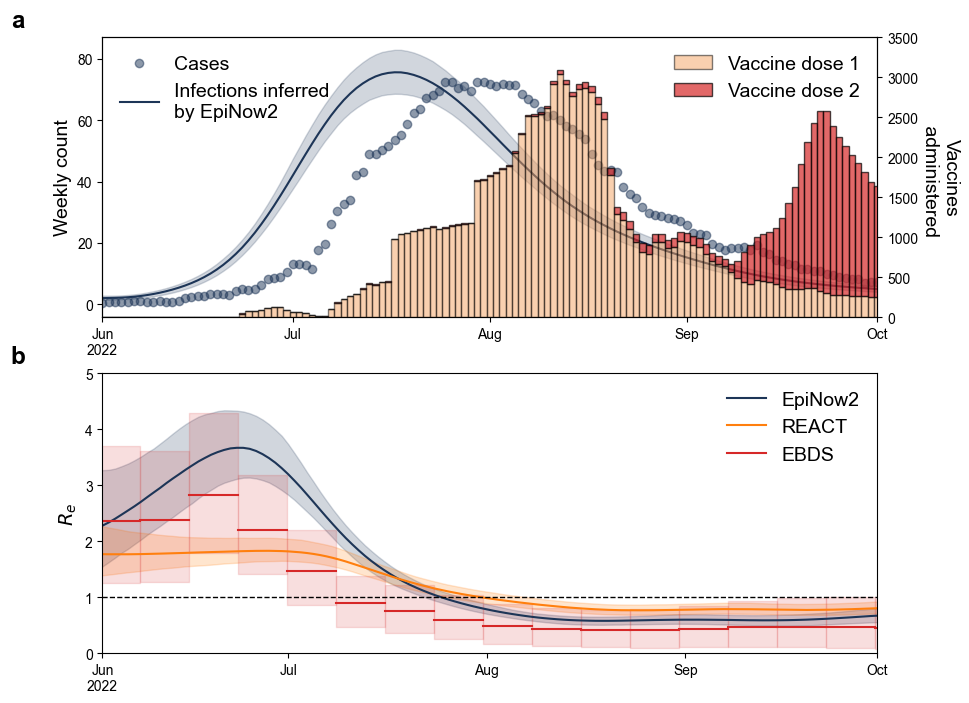

In [7]:
max_date = '2023-01-31'
max_date = toYearFraction(max_date)
max_data = 2023.0821917808219
earliest_date = toDatestring(2023.0821917808219-0.83835)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
fontsize=14

# plot cases
axes[0].scatter(cases_vaccines_genomes['date_float'], cases_vaccines_genomes['cases_daily_7d_ma'], color=cmap[1], alpha=0.5, label='Cases', zorder=1)
plot_results(axes[0], epinow_results[epinow_results['variable'] == 'infections'], 'date', 'median', 'lower_95', 'upper_95', color=cmap[1], label='Infections inferred\nby EpiNow2')
axes[0].set_ylabel('Weekly count', fontsize=fontsize)

# plot vaccines
axes0_twin = axes[0].twinx()
axes0_twin.bar(cases_vaccines_genomes['date_float'], cases_vaccines_genomes['admin_dose1_daily_7d_ma'], color=cmap[2], alpha=0.5, width=1/365, edgecolor='black', label='Vaccine dose 1', zorder=0)
axes0_twin.bar(cases_vaccines_genomes['date_float'], cases_vaccines_genomes['admin_dose2_daily_7d_ma'], bottom=cases_vaccines_genomes['admin_dose1_daily_7d_ma'], color=cmap[0], alpha=0.7, width=1/365, edgecolor='black', label='Vaccine dose 2', zorder=0)
axes0_twin.set_ylim(0, 3500)



# xticks at every month
xtick_labels = ['May', 'Jun\n2022', 'Jul', 'Aug', 'Sep', 'Oct']
xtick_values = [toYearFraction(f'2022-{m}-01') for m in range(5, 11)]
axes0_twin.set_xticks(xtick_values)
axes0_twin.set_xticklabels(xtick_labels)
axes0_twin.set_xlim(epinow_re['date_float'].min(), epinow_re['date_float'].max())
axes0_twin.set_ylabel('Vaccines\n administered', rotation=270, labelpad=30, fontsize=fontsize)

axes[0].legend(loc='upper left', fontsize=fontsize, frameon=False)
axes0_twin.legend(loc='upper right', fontsize=fontsize, frameon=False)


# plot effective reproduction number
plot_results(axes[1], epinow_results[epinow_results['variable'] == 'R'], 'date', 'median', 'lower_95', 'upper_95', color=cmap[1], label='EpiNow2')
plot_results(axes[1], reactidd_Rt, 'd_comb', 'r', 'lb_2.5', 'ub_97.5', color='#ff7f0e', label='REACT', linestyle='-')
plot_re_bins(max_date=max_date, earliest_date=earliest_date, num_bins=40, df=log_df, col_string='effective', ax=axes[1], leg=False, color=cmap[0], alpha=0.15)

xtick_labels = ['Mar', 'Apr', 'May', 'Jun\n2022', 'Jul', 'Aug', 'Sep', 'Oct']
xtick_values = [toYearFraction(f'2022-{m}-02') for m in range(3, 7)] + [toYearFraction(f'2022-{m}-01') for m in range(7, 11)]
axes[1].set_xticks(xtick_values)
axes[1].set_xticklabels(xtick_labels)
axes[1].set_xlim(toYearFraction('2022-06-02'), epinow_re['date_float'].max())
axes[1].set_ylim(0, 5)
axes[1].axhline(1, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel(None)
axes[1].set_ylabel('$R_e$', fontsize=fontsize)
axes[1].legend(frameon=False, loc='upper right', facecolor='white', fontsize=fontsize)

# add panel labels
axes[0].text(-0.1, 1.1, 'a', transform=axes[0].transAxes, fontsize=fontsize*1.25, fontweight='bold', va='top', ha='right')
axes[1].text(-0.1, 1.1, 'b', transform=axes[1].transAxes, fontsize=fontsize*1.25, fontweight='bold', va='top', ha='right')

plt.show()

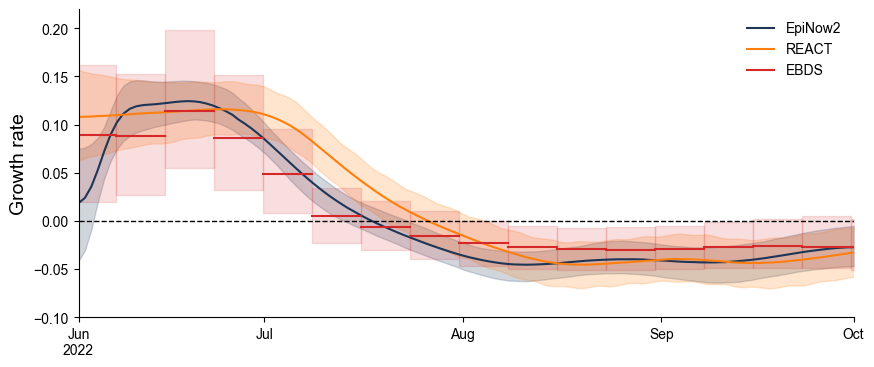

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4))

plot_results(axes, epinow_results[epinow_results['variable'] == 'growth_rate'], 'date', 'median', 'lower_95', 'upper_95', color=cmap[1], label='EpiNow2')
plot_results(axes, reactidd_growth, 'd_comb', 'r', 'lb_2.5', 'ub_97.5', color='#ff7f0e', label='REACT')
plot_re_bins(max_date=max_date, earliest_date=earliest_date, num_bins=40, df=log_df, col_string='growth_rate', ax=axes, leg=False, color=cmap[0], alpha=0.15)

axes.set_xticks(xtick_values)
axes.set_xticklabels(xtick_labels)
axes.set_xlim(toYearFraction('2022-06-02'), epinow_results['date_float'].max())
axes.set_ylim(-0.1, .22)
axes.axhline(0, color='black', linestyle='--', linewidth=1)
axes.set_xlabel(None)
axes.set_ylabel('Growth rate', fontsize=fontsize)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
plt.legend(frameon=False)

plt.show()